# Preprocessing of Expert-Eliciation Results

## Set up packages.

In [1]:
import numpy   as np
import pandas  as pd
import seaborn as sb

from scipy.optimize import fmin
from scipy.stats    import beta, triang

## Read percentile results.

In [2]:
expert_raw = pd.read_csv(
    "percentile_results.csv"
).set_index(
    ["Parameter", "Person_ID", "Type", "Question"]
).sort_index(
)[
    ["Quantile", "Value"]
]

## Fit results to Beta distributions.

In [3]:
def fit_beta_params(x, optimize = True, disp = False):
    x0 = x.set_index("Quantile")
    offset = x0.loc[0][0]
    scale = (x0.loc[1] - offset)[0]
    x1 = (x0.drop([0, 1]) - offset) / scale
    mu = np.mean(x1)[0]
    va = np.var(x1)[0]
    alpha0 = ((1 - mu) / va - 1 / mu) * mu**2
    beta0 = alpha0 * (1 / mu - 1)
    if optimize:
        def f(alpha_beta):
            p = beta.cdf(x0, alpha_beta[0], alpha_beta[1], offset, scale)[:,0]
            return np.mean((p - x0.index)**2)
        alpha1, beta1 = fmin(f, [alpha0, beta0], disp = disp)
        return beta(alpha1, beta1, offset, scale)
    else:
        return beta(alpha0, beta0, offset, scale)

In [4]:
expert_fit = expert_raw.groupby(["Parameter", "Person_ID", "Type", "Question"]).apply(fit_beta_params)

/nix/store/2hqyq1p29z76wvh920r43a63sy9n1cag-python3-3.7.6-env/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


### Text representation of fit Beta distributions.

In [5]:
pd.DataFrame(expert_fit.apply(lambda f: "st.beta" + str(np.round(f.args, 2)).replace("[", "(").replace("]", ")")))

0
Parameter       Person_ID Type               Question                                                        
Kerf Loss       31        Annual Improvement Status Quo          st.beta(1.58e+01 4.80e+00 1.00e-02 4.49e+00)
                                             Unlimited R&D                   st.beta(11.2   3.05  1.97  4.49)
                                             x5 R&D                          st.beta(16.56  5.03  1.02  4.48)
                          Direct Value       Status Quo     st.beta(2.1260e+01 1.8940e+01 4.0000e-02 1.390...
                                             Unlimited R&D                   st.beta( 2.46  2.67  4.97 73.87)
...                                                                                                       ...
Wafer Thickness 51        Direct Value       Unlimited R&D                   st.beta( 8.67 26.05 45.29 54.3 )
                                             x5 R&D                          st.beta( 6.31 29.5  70.16 29.69)
                52        Direct Value       Status Quo          st.beta(1.14e+00 1.11e+00 1.50e+02 1.00e-02)
                                             Unlimited R&D  st.beta(1.1488e+02 5.4620e+01 1.5032e+02 3.000...
                                             x5 R&D         st.beta(1.0700e+00 1.0300e+00 1.5007e+02 1.000...

[198 rows x 1 columns]

### Plots of fits.

In [6]:
np.unique(expert_fit.reset_index()["Person_ID"])

array([31, 32, 33, 34, 35, 36, 38, 39, 40, 45, 46, 47, 48, 49, 50, 51, 52])

In [7]:
expert_raw.xs(["Kerf Loss", "Direct Value"], level = ["Parameter", "Type"])["Value"].max()

139.11224267685301

In [8]:
kl_ref = np.arange(0, 150, 1)

In [9]:
expert_sample = expert_fit.to_frame(
    name = "Distribution"
).xs(
    ["Kerf Loss", "Direct Value"], level = ["Parameter", "Type"]
).groupby(
    ["Question", "Person_ID"]
).apply(
    lambda f: pd.DataFrame({"Value" : kl_ref, "Probability" : f.iloc[0][0].pdf(kl_ref)})
)

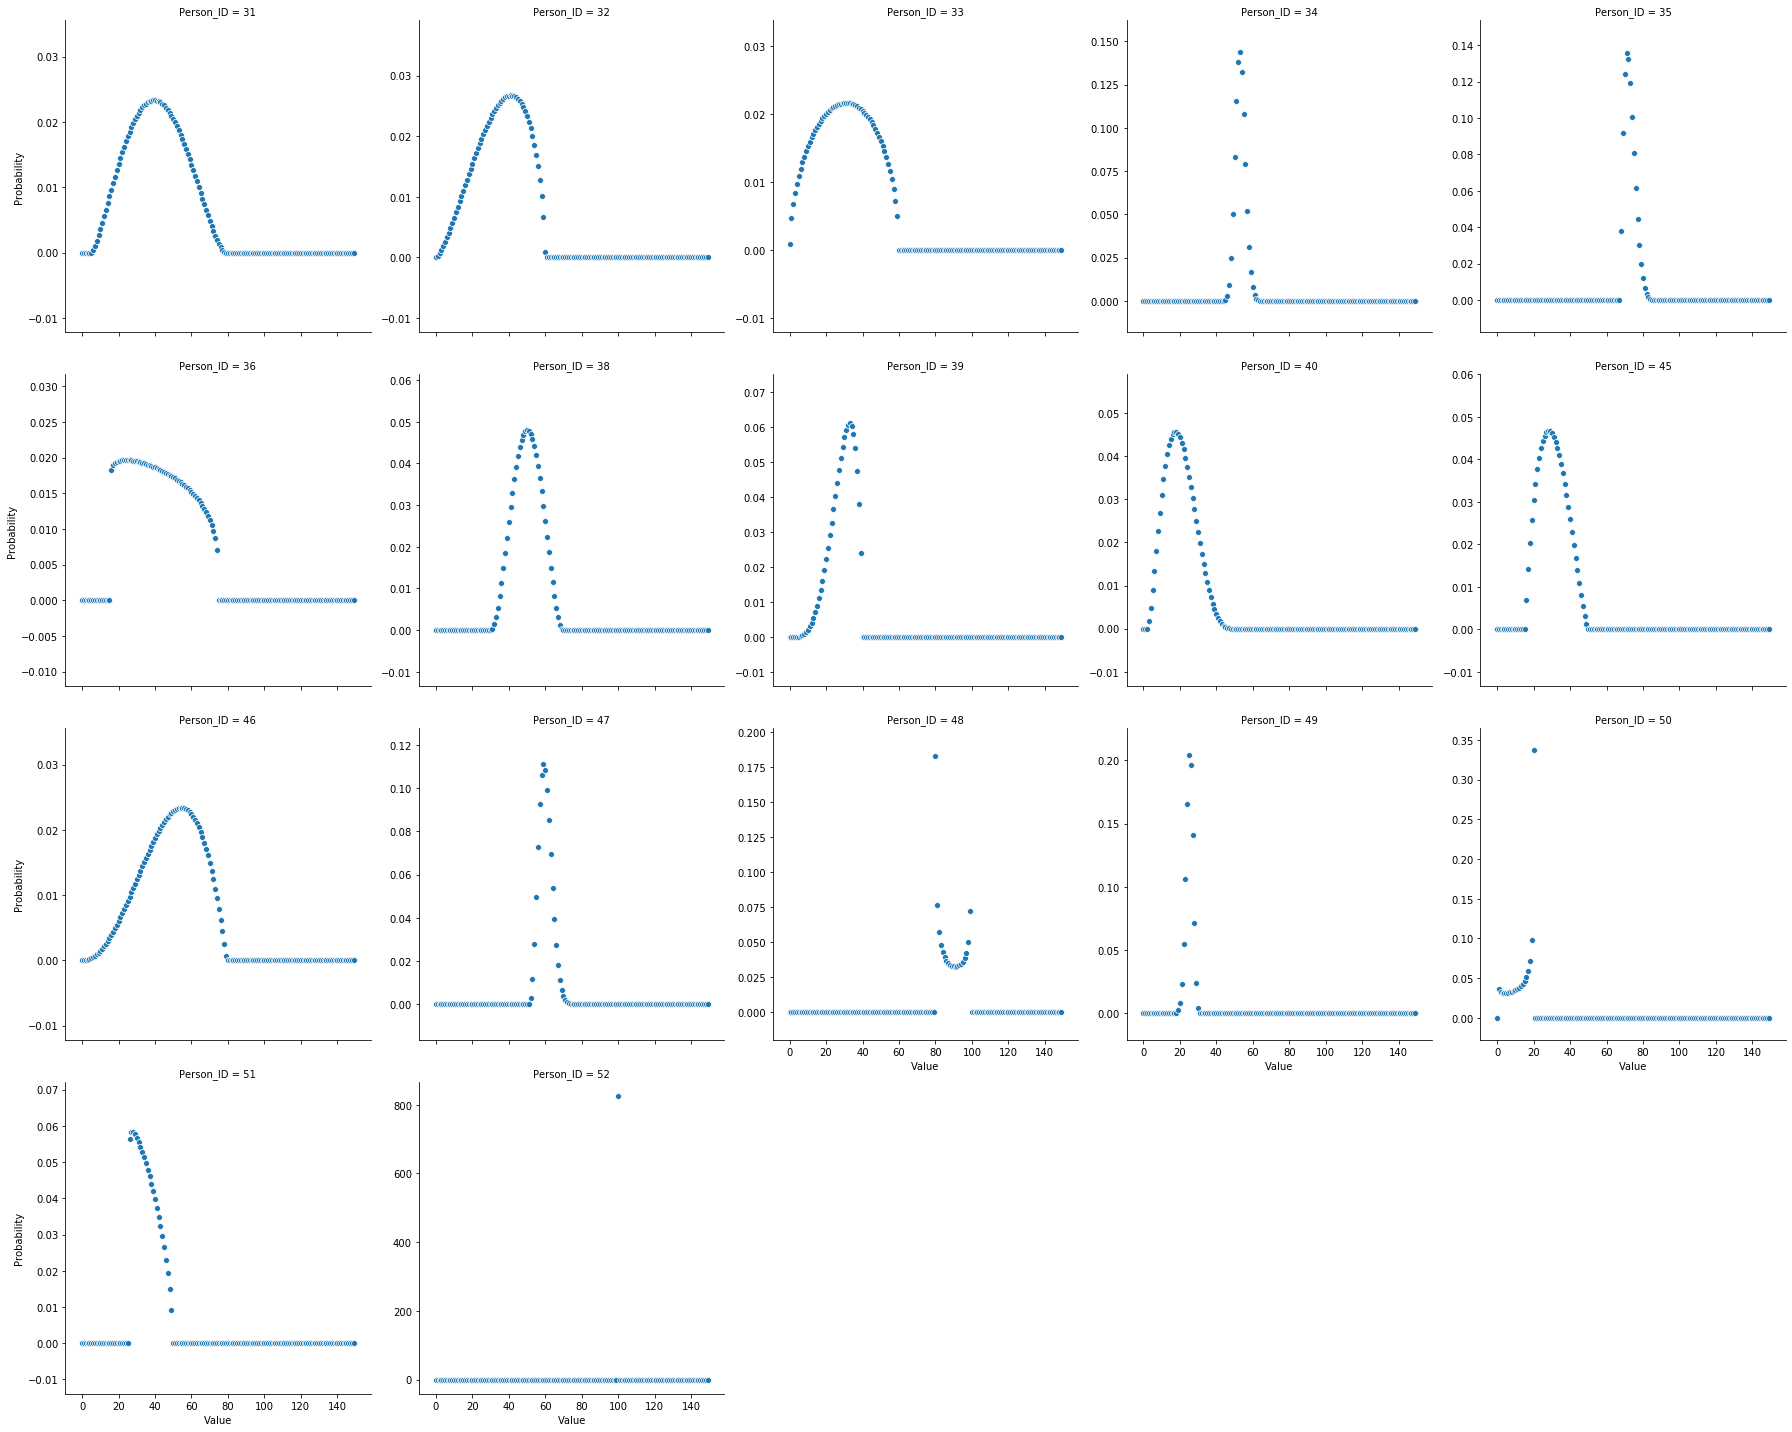

In [10]:
sb.relplot(
    data = expert_sample.xs(["Unlimited R&D"]).reset_index(),
    x = "Value",
    y = "Probability",
    col = "Person_ID",
    col_wrap = 5,
    facet_kws={'sharey': False, 'sharex': True}
)

In [11]:
debug_person = 48

In [12]:
x_test = expert_raw.xs(["Kerf Loss", debug_person, "Direct Value", "Unlimited R&D"]).sort_values("Quantile")
x_test

Quantile      Value
Parameter Person_ID Type         Question                          
Kerf Loss 48        Direct Value Unlimited R&D       0.0  79.773133
                                 Unlimited R&D       0.1  80.241959
                                 Unlimited R&D       0.5  87.125987
                                 Unlimited R&D       0.9  99.054345
                                 Unlimited R&D       1.0  99.653730

In [13]:
x_fit = fit_beta_params(x_test.reset_index(drop = True), optimize = True, disp = True)
np.mean((x_fit.cdf(x_test["Value"]) - x_test.set_index("Quantile").index)**2), x_fit.cdf(x_test["Value"])

Optimization terminated successfully.
         Current function value: 0.000345
         Iterations: 35
         Function evaluations: 65


(0.0003445636021884788,
 array([0.        , 0.12434074, 0.47654954, 0.92409196, 1.        ]))

In [15]:
def fit_triang_params(x, optimize = True, disp = False):
    x0 = x.set_index("Quantile")
    offset = x0.loc[0][0]
    scale = (x0.loc[1][0] - offset)
    x1 = (x0.drop([0, 1]) - offset) / scale
    mu = np.mean(x1)[0]
    alpha0 = mu
    if optimize:
        def f(alpha):
            p = triang.cdf(x0, alpha[0], offset, scale)[:,0]
            return np.mean((p - x0.index)**2)
        alpha1 = fmin(f, [alpha0], disp = disp)
        return triang(alpha1, offset, scale)
    else:
        return triang(alpha0, offset, scale)

In [16]:
x_fit = fit_triang_params(x_test.reset_index(drop = True), optimize = True, disp = True)
np.mean((x_fit.cdf(x_test["Value"]) - x_test.set_index("Quantile").index)**2), x_fit.cdf(x_test["Value"])

Optimization terminated successfully.
         Current function value: 0.003847
         Iterations: 14
         Function evaluations: 28


(0.003847187493344393,
 array([0.        , 0.0027421 , 0.50189265, 0.99885978, 1.        ]))

In [17]:
x_fit = fit_triang_params(x_test.reset_index(drop = True), optimize = False, disp = True)
x_fit.args

(0.4544278424770684, 79.7731332351912, 19.8805970149254)

In [18]:
x_fit.cdf(x_test["Value"])

array([0.        , 0.00122377, 0.30101492, 0.9983339 , 1.        ])

In [19]:
np.mean((x_fit.cdf(x_test["Value"]) - x_test.set_index("Quantile").index)**2)

0.011804272278323877

In [20]:
x_fit = fit_triang_params(x_test.reset_index(drop = True), optimize = True, disp = True)
x_fit.args

Optimization terminated successfully.
         Current function value: 0.003847
         Iterations: 14
         Function evaluations: 28


(array([0.20280618]), 79.7731332351912, 19.8805970149254)

In [21]:
x_fit.cdf(x_test["Value"])

array([0.        , 0.0027421 , 0.50189265, 0.99885978, 1.        ])

In [22]:
np.mean((x_fit.cdf(x_test["Value"]) - x_test.set_index("Quantile").index)**2)

0.003847187493344393

In [23]:
x_fit.cdf(x_test["Value"])

array([0.        , 0.0027421 , 0.50189265, 0.99885978, 1.        ])

In [24]:
x_fit = fit_beta_params(x_test.reset_index(drop = True), optimize = True, disp = True)
x_fit.args

Optimization terminated successfully.
         Current function value: 0.000345
         Iterations: 35
         Function evaluations: 65


(0.46832459493135437, 0.5812313788033674, 79.7731332351912, 19.8805970149254)

In [25]:
x_fit = fit_triang_params(x_test.reset_index(drop = True), optimize = True, disp = True)
x_fit.args

Optimization terminated successfully.
         Current function value: 0.003847
         Iterations: 14
         Function evaluations: 28


(array([0.20280618]), 79.7731332351912, 19.8805970149254)

In [26]:
np.mean((x_fit.cdf(x_test["Value"]) - x_test.set_index("Quantile").index)**2)

0.003847187493344393

In [27]:
expert_fit = expert_raw.groupby(["Parameter", "Person_ID", "Type", "Question"]).apply(fit_triang_params)

/nix/store/2hqyq1p29z76wvh920r43a63sy9n1cag-python3-3.7.6-env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6815: RuntimeWarning: invalid value encountered in greater_equal
  return (c >= 0) & (c <= 1)
/nix/store/2hqyq1p29z76wvh920r43a63sy9n1cag-python3-3.7.6-env/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:6815: RuntimeWarning: invalid value encountered in less_equal
  return (c >= 0) & (c <= 1)


In [28]:
expert_sample = expert_fit.to_frame(
    name = "Distribution"
).xs(
    ["Kerf Loss", "Direct Value"], level = ["Parameter", "Type"]
).groupby(
    ["Question", "Person_ID"]
).apply(
    lambda f: pd.DataFrame({"Value" : kl_ref, "Probability" : f.iloc[0][0].pdf(kl_ref)})
)

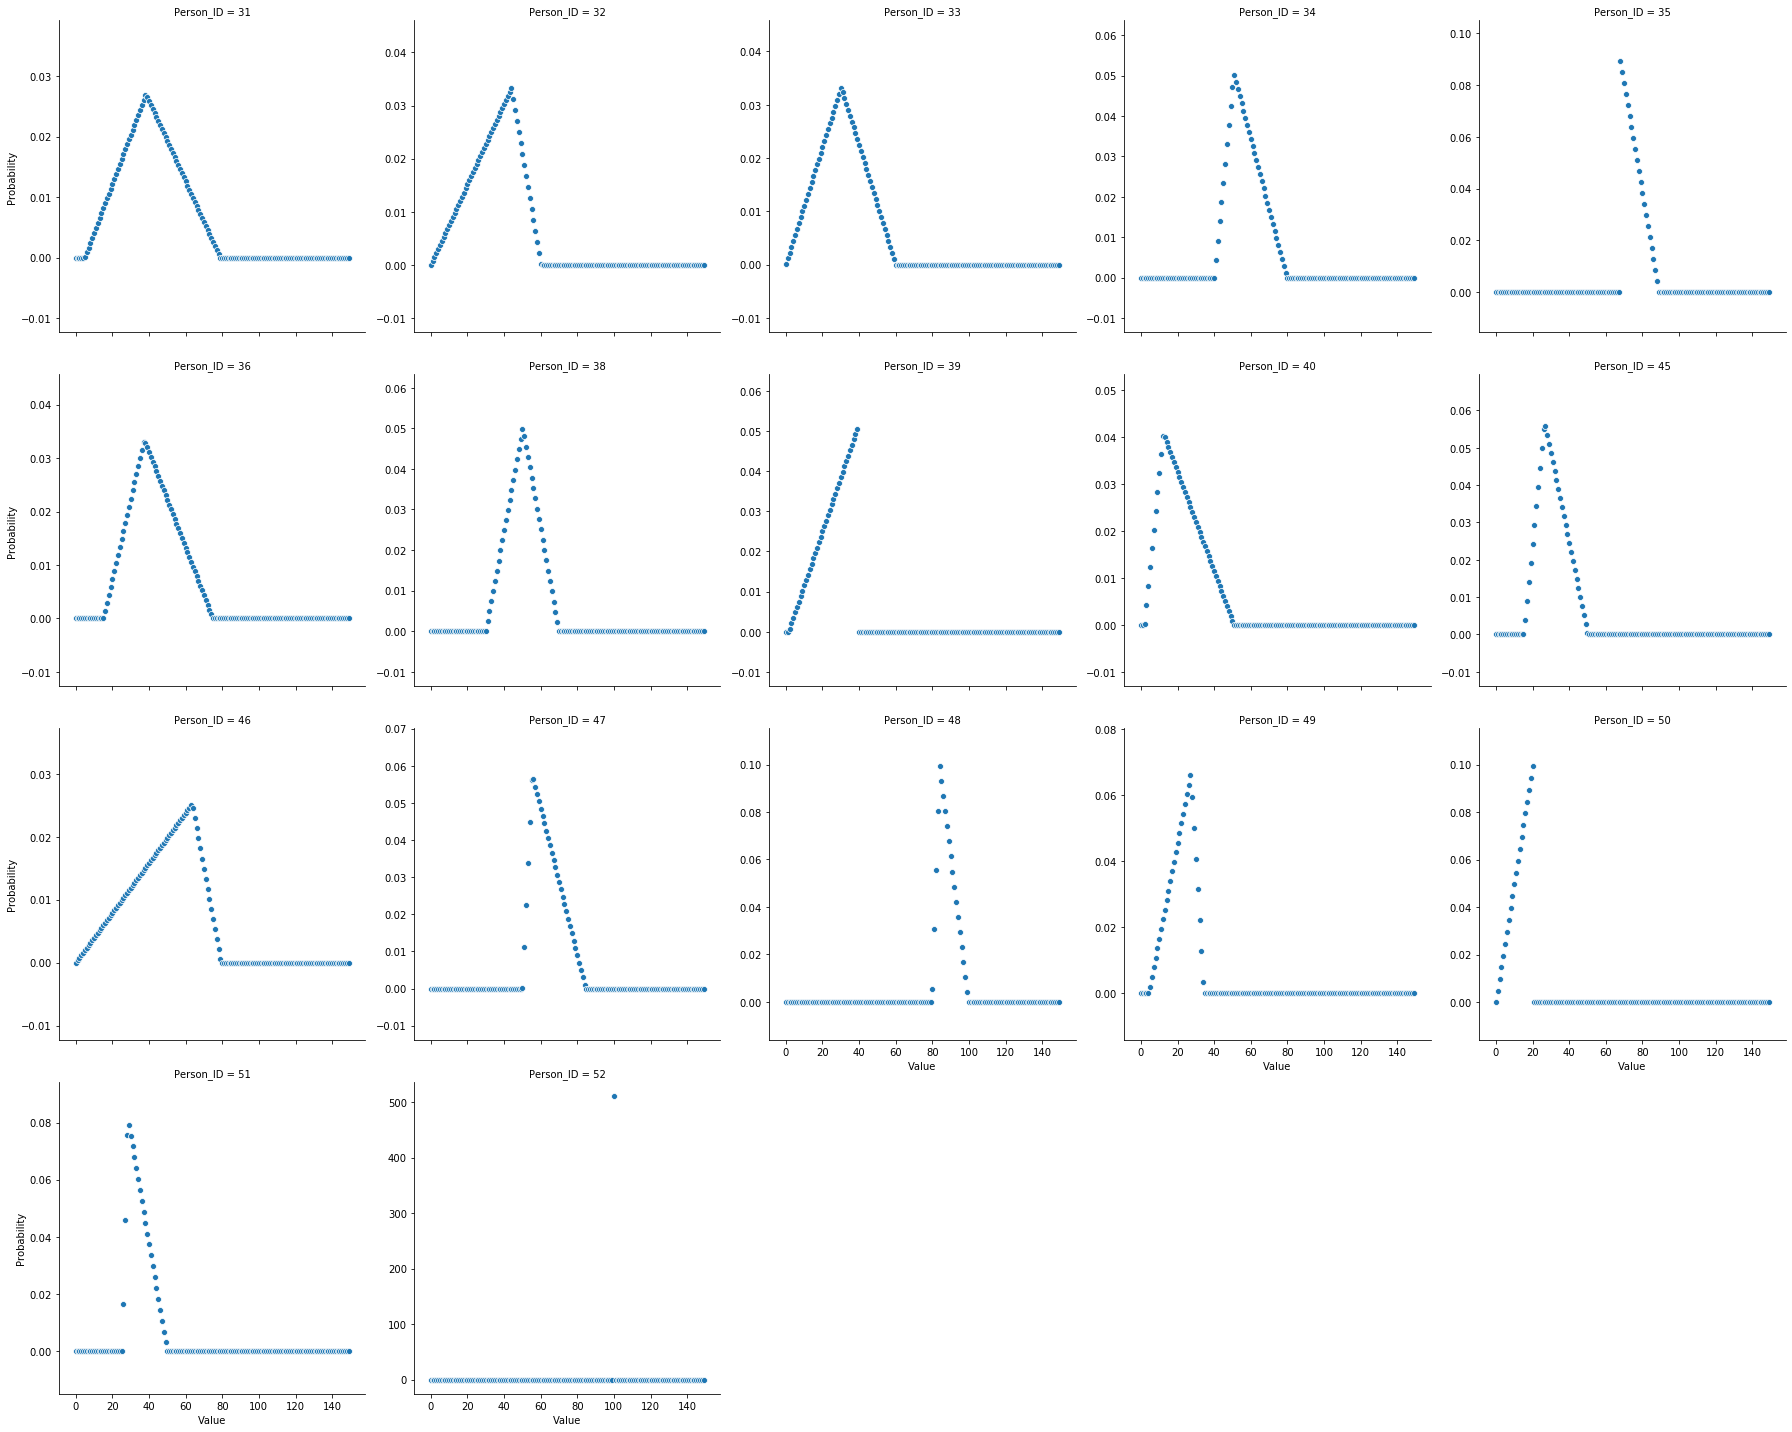

In [29]:
sb.relplot(
    data = expert_sample.xs(["Unlimited R&D"]).reset_index(),
    x = "Value",
    y = "Probability",
    col = "Person_ID",
    col_wrap = 5,
    facet_kws={'sharey': False, 'sharex': True}
)